# Исследование поведения пользователей в приложении для продажи продуктов

# Введение

**Цель проекта** - изучить поведение пользователей в приложении для продажи продуктов. <br>А именно:
* *Изучить воронки продаж для определения пути пользователей до покупки и возможных мест "застревания", препятствующих совершению покупки;*
* *Изучить влияние разных шрифтов на привлечение пользователей. Для этого необходимо разбить данные на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Провести A/A/B-эксперимент и выяснить, какой шрифт лучше.*

**Описание данных**
<br>Каждая запись в логе — это действие пользователя, или событие.
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимен 246 и 247 - контрольные группы, 248 - экспериментальная.

Проект будет выполнен по плану, представленному ниже.

# План работы

1. [**Загрузка данных.**](#1-bullet)

2. [**Подготовка данных.**](#2-bullet)

3. [**Исследовательский анализ данных.**](#3-bullet)
   
4. [**Изучение воронки событий.**](#4-bullet)
   
5. [**Изучение результатов эксперимента.**](#5-bullet)

6. [**Общий вывод.**](#6-bullet)

**Импортируем необходимые библиотеки.**

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import warnings

import numpy as np

import plotly as pl

import seaborn as sns

from scipy import stats as st

import datetime as dt

import plotly.express as px

from statsmodels.stats.proportion import proportions_ztest

from plotly import graph_objects as go

In [2]:
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_colwidth', 500) 

<a class='anchor' id='1-bullet'></a>
## Загрузка данных

In [4]:
# считаем данные и поместим в переменную 'data'
try:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    data = pd.read_csv(r"C:\Users\Александр\Desktop\Аналитика данных\ПРОЕКТЫ\СБОРНЫЙ ПРОЕКТ 2\logs_exp.csv", sep='\t')

In [5]:
# выведем первые 10 строк датафрейма
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [6]:
# выведем общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Вывод 1**

В датафрейме 244126 строк и 4 столбца.  Типы данных - *object* и *int64*.

Во всех столбцах данные полные, пропусков не наблюдается.

<a class='anchor' id='2-bullet'></a>
## Подготовка данных

### Заменим названия столбцов (переименуем и приведем к нижнему регистру).

In [7]:
# переименуем столбцы на более привычные в нижнем регистре
data = data.rename(columns = {'EventName': 'event_name', 'DeviceIDHash': 'device_id_hash', 'EventTimestamp': 'event_timestamp', 'ExpId': 'exp_id'})

*Вывод 2.1*

Столбцы успешно переименованы и приведены к удобному виду.

### Преобразуем типы данных и добавим новые столбцы.

* Преобразуем столбец *"event_timestamp"* в формат даты времени "datetime" из формата "unix time";
* Добавим столбец *"event_date"*, содержащий дату.

In [8]:
# преобразуем тип данных столбца "event_timestamp" в "datetime" из "unix time"
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')
# добавим столбец "event_date" с датой
data['event_date'] = data['event_timestamp'].dt.date

# выведем первые 5 строк
data.head(5)

,event_name,device_id_hash,event_timestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


*Вывод 2.2*

Столбцы с датой и временем (*"event_timestamp"*) и усеченной датой (*"event_date"*) добавлены успешно.

### Обработка пропусков.

In [9]:
# выведем данные о пропусках
data.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
event_date         0
dtype: int64

*Вывод 2.3*

Пропусков в датафрейме не нашлось.

### Обработка дубликатов.

In [10]:
# выведем количество явных дубликатов
cnt_dup = data.duplicated().sum()

print(f'''Количество полных дубликатов {cnt_dup}
Данное количество составляет {cnt_dup/data.shape[0]:.3%} от общего объема данных.''')

Количество полных дубликатов 413
Данное количество составляет 0.169% от общего объема данных.


In [11]:
# удалим полные дубликаты
data = data.drop_duplicates().reset_index(drop=True)

**Проверим группы на присутствие одних и тех же пользователей в разных группах.**

In [12]:
# создадим список уникальных пользователей для группы 246
group_246 = data['device_id_hash'].loc[data['exp_id'] == 246].unique()
# создадим список уникальных пользователей для группы 247
group_247 = data['device_id_hash'].loc[data['exp_id'] == 247].unique()
# создадим список уникальных пользователей для группы 248
group_248 = data['device_id_hash'].loc[data['exp_id'] == 248].unique()

In [13]:
# проверим пересекающихся пользователей
print(f'Количество пересечений между группой 246 и 247 составляет {len(np.intersect1d(group_246, group_247))}')
print(f'Количество пересечений между группой 246 и 248 составляет {len(np.intersect1d(group_246, group_248))}')
print(f'Количество пересечений между группой 247 и 248 составляет {len(np.intersect1d(group_247, group_248))}')

Количество пересечений между группой 246 и 247 составляет 0
Количество пересечений между группой 246 и 248 составляет 0
Количество пересечений между группой 247 и 248 составляет 0


In [14]:
# проведем дополнительную проверку на наличие пересекающихся пользователей в разных выборках
data.groupby('device_id_hash')['exp_id'].nunique().reset_index().query('exp_id > 1')

,device_id_hash,exp_id


**ВЫВОД 2**

1. Переименовали названия столбцов на более удобные.
2. Преобразовали тип данных с "unix time" на "datetime", тем самым поместив в столбец "event_timestamp" данные о дате и времени. Также добавили столбец "event_day" с датой.
3. Проверили данные на наличие пропусков. Пропусков не оказалось.
4. Проверили данные на наличие полных дубликатов. Их оказалось 413, что составило всего 0.169% от общего объема данных. Удалили данные дубликаты.
5. Проверили группы 246, 247 и 248 на наличие пересекающихся значений в столбце "device_id_hash". Таковых не оказалось.

<a class='anchor' id='3-bullet'></a>
## Исследовательский анализ данных

### Выведем данные о количестве событий и пользователей

In [15]:
# подсчитаем количество событий и пользователей в логе
events = data['event_name']
users = data['device_id_hash']

print(f'Общее количество событий в логе составляет {len(events)}')
print(f'Количество уникальных событий составляет {events.nunique()}')
print(f'Общее количество уникальных пользователей составляет {users.nunique()}')
print(f'В среднем на пользователя приходится {len(events) / users.nunique():.1f} событий')

Общее количество событий в логе составляет 243713
Количество уникальных событий составляет 5
Общее количество уникальных пользователей составляет 7551
В среднем на пользователя приходится 32.3 событий


**Исследуем количество событий на пользователя.**

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64


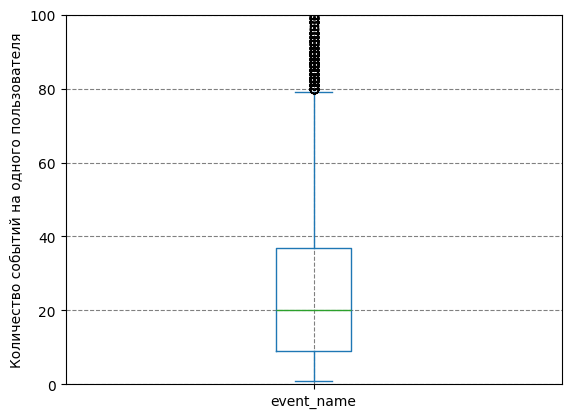

In [16]:
# посчитаем количество событий, сгруппированное на пользователя
user_cnt_event = data.groupby('device_id_hash')['event_name'].count().sort_values()
print(user_cnt_event.describe())

# построим диаграмму размаха
plt.ylim(0, 100)
user_cnt_event.plot.box()
plt.grid(True, linestyle='--', color='grey')
plt.ylabel('Количество событий на одного пользователя')

plt.show()

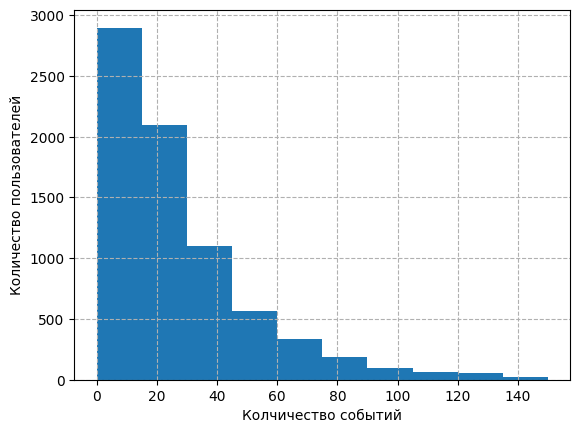

In [17]:
user_cnt_event.plot.hist(range = (0, 150), bins = 10)
plt.grid(True, linestyle='--')
plt.xlabel('Колчичество событий')
plt.ylabel('Количество пользователей')

plt.show()

*Описание данных о количестве событий на одного пользователя, а также построение диаграммы размаха и гистограммы распределения показали, что медианное значение находитя на отметке в 20 событий на одного пользователя.* **При этом, подавляющее большинство пользователей совершают до 40 событий. Однако, нормальным значением можем признать границу в 80 событий. Значения количества событий, превышающие 80 событий признаем аномальным.**

### Построим графики количества событий и пользователей по группам

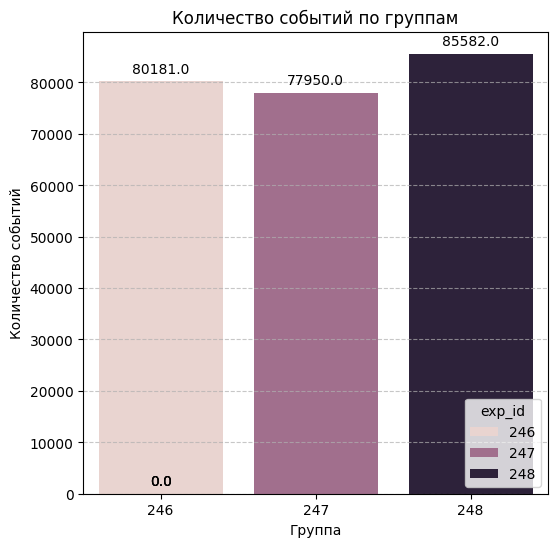

In [18]:
# Построим столбчатую диаграмму с количеством событий по группам
event_group = data.groupby('exp_id', as_index=False).agg({'event_name': 'count'})

plt.figure(figsize=(6, 6))
splot=sns.barplot(data=event_group, x="exp_id", y="event_name", hue='exp_id')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Количество событий по группам')
plt.ylabel('Количество событий')
plt.xlabel('Группа')

plt.show()

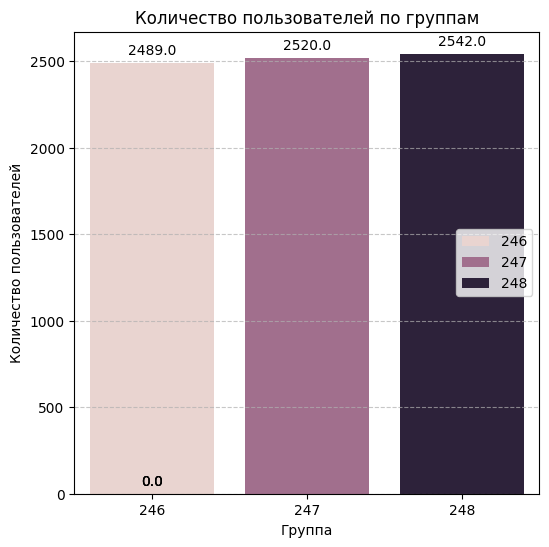

In [19]:
# Построим столбчатую диаграмму с количеством пользователей по группам
users_group = data.groupby('exp_id', as_index=False).agg({'device_id_hash': 'nunique'})

plt.figure(figsize=(6, 6))
splot=sns.barplot(data=users_group, x="exp_id", y="device_id_hash", hue='exp_id')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Количество пользователей по группам')
plt.ylabel('Количество пользователей')
plt.xlabel('Группа')
plt.legend(loc='center right')

plt.show()

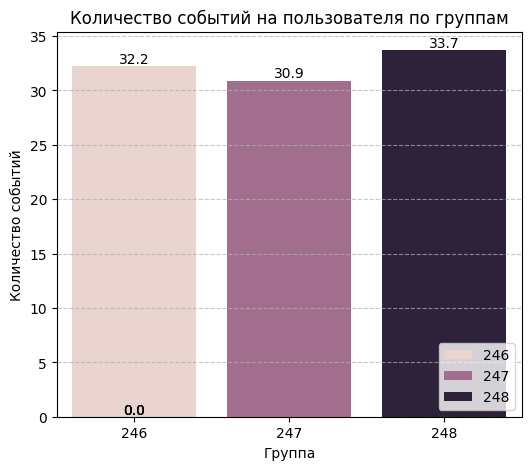

In [20]:
# построим столбчатую диаграмму количества событий на пользователя по группам
e_u_group = event_group.merge(users_group, on='exp_id')
e_u_group['event_per_user'] = np.round(e_u_group['event_name'] / e_u_group['device_id_hash'], 1)

plt.figure(figsize=(6, 5))
splot=sns.barplot(data=e_u_group, x="exp_id", y="event_per_user", hue='exp_id')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Количество событий на пользователя по группам')
plt.ylabel('Количество событий')
plt.xlabel('Группа')
plt.legend(loc='lower right')

plt.show()

### Исследуем динамику изменения количества данных с течением времени

In [21]:
# Выведем минимальную и максимальную даты
min_date = data['event_timestamp'].min()
max_date = data['event_timestamp'].max()
print("Минимальная дата:", min_date)
print("Максимальная дата:", max_date)

Минимальная дата: 2019-07-25 04:43:36
Максимальная дата: 2019-08-07 21:15:17


In [22]:
# создадим датафрейм с количеством событий по группам и датам
events_per_day = data.groupby(['event_date', 'exp_id']).agg({'exp_id': 'count'}).unstack()
events_per_day.columns = [246, 247, 248]
events_per_day.head(5)

,246,247,248
event_date,,,
2019-07-25,4,1,4
2019-07-26,14,8,9
2019-07-27,24,23,8
2019-07-28,33,36,36
2019-07-29,55,58,71


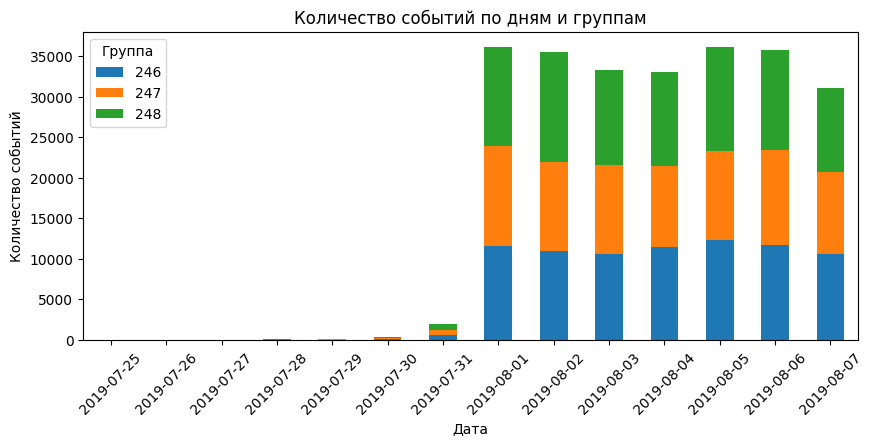

In [23]:
# построим столбчатую диаграмму с изменением количества событий по времени в разраезе групп
events_per_day.plot(kind='bar',  stacked=True, figsize=(10, 4))
plt.title("Количество событий по дням и группам")
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.legend(title="Группа")
plt.xticks(rotation=45)
plt.show()

**Диаграмма показала, что данные начинают отличаться полнотой с 01.08.2019. Отсечем данные за предыдущий промежуток времени.**

In [24]:
# создадим датафрейм "data_full" с данными от 01-08-2019
data['event_date'] = pd.to_datetime(data['event_date'])
data_full = data[data['event_date'] >= pd.to_datetime('2019-08-01')]
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240887 entries, 2826 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       240887 non-null  object        
 1   device_id_hash   240887 non-null  int64         
 2   event_timestamp  240887 non-null  datetime64[ns]
 3   exp_id           240887 non-null  int64         
 4   event_date       240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.0+ MB


In [25]:
# подсчитаем количество потерянных событий и пользователей после отсечения
cnt_poter_events = data.shape[0] - data_full.shape[0]
cnt_poter_users = data['device_id_hash'].nunique() - data_full['device_id_hash'].nunique()

print(f'''После отсечения событий, произошедших до 01-08-2019 количество данных сократилось на {cnt_poter_events} события\
 или на {cnt_poter_events / data.shape[0]:.2%}.
А количество потерянных пользователей равно {cnt_poter_users}''')

После отсечения событий, произошедших до 01-08-2019 количество данных сократилось на 2826 события или на 1.16%.
А количество потерянных пользователей равно 17


In [26]:
# проверим наличие пользователей из всех 3 групп
data_full.groupby('exp_id')['device_id_hash'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

### Построим столбчатые графики после очистки данных

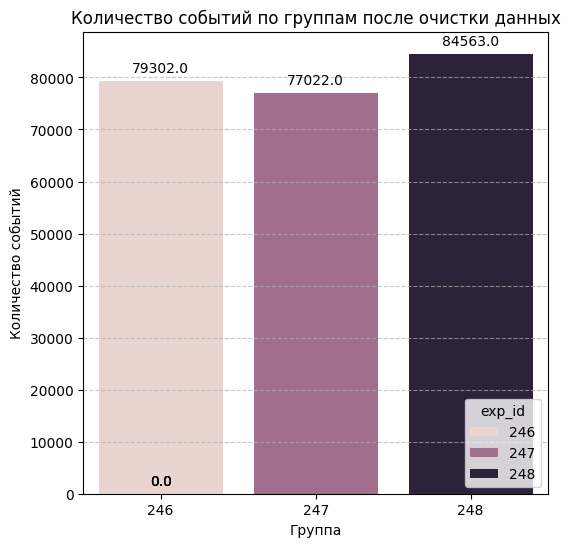

In [27]:
# Построим столбчатую диаграмму с количеством событий по группам после очистки данных
event_group_full = data_full.groupby('exp_id', as_index=False).agg({'event_name': 'count'})

plt.figure(figsize=(6, 6))
splot=sns.barplot(data=event_group_full, x="exp_id", y="event_name", hue='exp_id')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Количество событий по группам после очистки данных')
plt.ylabel('Количество событий')
plt.xlabel('Группа')

plt.show()

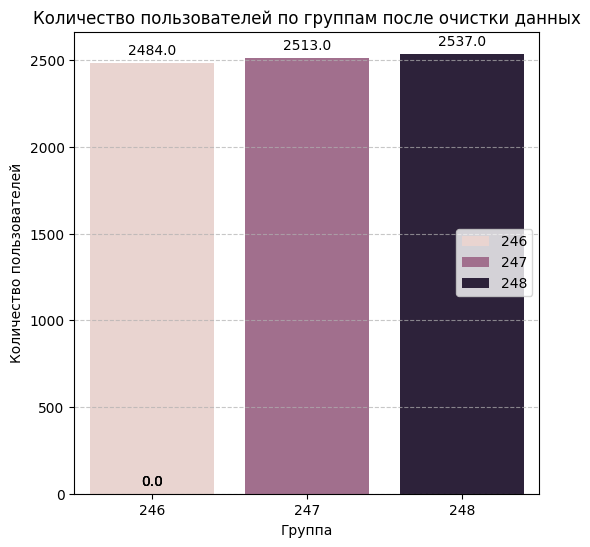

In [28]:
# Построим столбчатую диаграмму с количеством пользователей по группам после очистки данных
users_group_full = data_full.groupby('exp_id', as_index=False).agg({'device_id_hash': 'nunique'})

plt.figure(figsize=(6, 6))
splot=sns.barplot(data=users_group_full, x="exp_id", y="device_id_hash", hue='exp_id')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Количество пользователей по группам после очистки данных')
plt.ylabel('Количество пользователей')
plt.xlabel('Группа')
plt.legend(loc='center right')

plt.show()

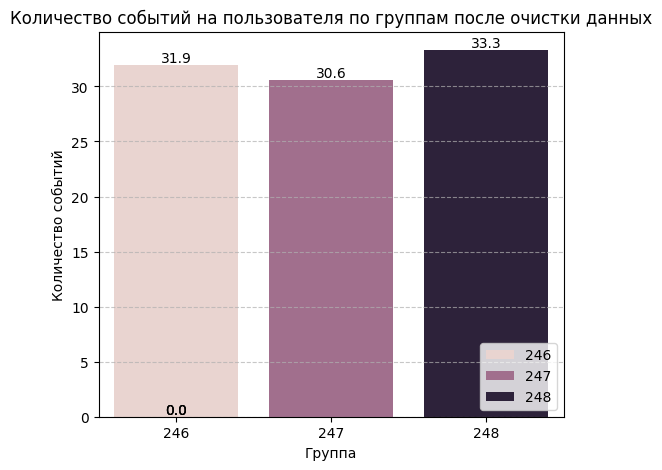

In [29]:
# построим столбчатую диаграмму количества событий на пользователя по группам после очистки данных
e_u_group_full = event_group_full.merge(users_group_full, on='exp_id')
e_u_group_full['event_per_user'] = np.round(e_u_group_full['event_name'] / e_u_group_full['device_id_hash'], 1)

plt.figure(figsize=(6, 5))
splot=sns.barplot(data=e_u_group_full, x="exp_id", y="event_per_user", hue='exp_id')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Количество событий на пользователя по группам после очистки данных')
plt.ylabel('Количество событий')
plt.xlabel('Группа')
plt.legend(loc='lower right')

plt.show()

**ВЫВОД 3**

В данном разделе был проведен исследовательский анализ данных
.
1. *Стало известно следующее:*
   * Начальные данные охватывают период с 25-07-2019 по 07-08-2019. 
   * Общее количество событий в логе составляет 243713
   * Количество уникальных событий составляет 5
   * Общее количество уникальных пользователей составляет 7551
   * В среднем на пользователя приходится 32.3 событий
   * Медианное значение количества событий на пользователя равно 20
   * Нормальным диапазоном значений количества событий на пользователя признан следующий: от 1 до 80 событий.
3. *Построение столбчатых графиков показало:*
   * Количество событий распределено практически равномерно по группам. Однако, группа 248 отличается наибольшим количеством событий (85582), за ней расположилась группа 246 (80181 событий) и 247 (77950) - самая немногочисленная.
   * По количеству пользователей на первом месте также группа 248 (2542 пользователя), затем группа 247 (2520) и 246 (2489 пользователей).
   * По количеству событий на пользователя лидирует группа 248 (33.7), затем группа 246 (32.2) и 247 (30.9).
4. *Столбчатый график динамики изменения количества событий по дням и группам показал*, что полнота данных начинается лишь с 01-08-2019. По этой причине мы отсекли события, предшествующие этой дате, тем самым "потеряв" 2826 событий (лишь 1.16% данных) и 17 пользователей.
5. *Построение столбчатых графиков после очистки данных* также подтвердило равномерность удаленных данных, так как распределение мест по количеству событий, пользователей и событий, приходящихся на пользователей осталось прежним.

**Итог**

**Мы избавились от неполных данных, при этом никак не повлияв на прежнее распределение данных. Нынешний промежуток наблюдений - с 01-08-2019 по 07-08-2019.  Теперь можно смело приступать к дальнейшим исследованиям.**

<a class='anchor' id='4-bullet'></a>
## Изучение воронки событий

### Изучим события в логах

In [30]:
data_full.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


In [31]:
# посчитаем частоту событий
events_cnt = data_full.groupby('event_name', as_index=False).size().sort_values(by='size', ascending=False)
print('Частота событий')
events_cnt

Частота событий


,event_name,size
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


In [32]:
# посчитаем количество пользователей, участвовавших в событиях
events_user_cnt = data_full.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending=False)
print('Количество пользователей в каждом событии')
events_user_cnt

Количество пользователей в каждом событии


event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: device_id_hash, dtype: int64

In [33]:
# посчитаем долю пользователей хоть раз совершавших событие
user_cnt = data_full['device_id_hash'].nunique()
events_user_ratio = (events_user_cnt / user_cnt).sort_values(ascending=False)
print('Доля пользователей участвовавших в каждом событии относительно первоначального общего количества пользователей.')
events_user_ratio

Доля пользователей участвовавших в каждом событии относительно первоначального общего количества пользователей.


event_name
MainScreenAppear           0.984736
OffersScreenAppear         0.609636
CartScreenAppear           0.495620
PaymentScreenSuccessful    0.469737
Tutorial                   0.111495
Name: device_id_hash, dtype: float64

**На основании рассчитанной частоты событий можно сделать предположение о последовательности событий:**
1. *MainScreenAppear* - Основной экран приложения. Об этом говорит и доля пользователей, равная 98% от обшего числа. Недостающие 2%, скорее всего приходятся на сбои в работе приложения, либо его закрытие, без достижения полной прогрузки.
2. *OffersScreenAppear* - Экран с товарами. На него переходят уже с основного экрана, что является логичным и последовательным событием. Доля в 61% это подтверждает.
3. *CartScreenAppear* - Экран корзины. После просмотра товаров пользователь добавляет какие-то из них в корзину. Процент снова уменьшился и равняется почти 50%.
4. *PaymentScreenSuccessful* - Экран успешной оплаты. Это событие происходит с 47% пользователей. Не все совершают покупки даже после добавления в корзину.
5. *Tutorial* - Обучение. Доля совсем мала и составляет чуть более 11%. Скорее всего это инструкция к пользованию приложением. Большая часть пользователей это событие пропускают.

Частота событий выглядит логичной. "Tutorial" исключим из последовательности сразу, так как данное событие не вписывается в логику последовательности совершения покупки. По итогу наша последовательность будет выглядеть так:
1. MainScreenAppear
2. 
OffersScreenAppea
3. CartScreenAppear
4. PaymentScreenSuccessful

А вот 2%, которые, как бы потерялись уже на первом экране, рискнем объяснить тем, что пользователям дается выбор после скачивания приложения о переходе на главный экран, либо сразу к товарам. Либо же в какой-то из дней пытались поднять продажи, сразу представляя пользователю экран с товарами, чтобы сократить путь до покупки.

**Построим воронку для последовательности событий с количеством уникальных пользователей**

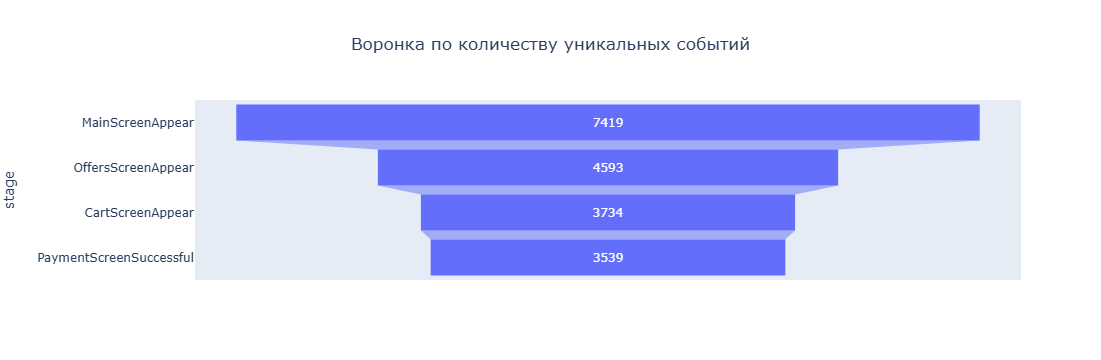

In [36]:
# создадим списки с названиями событий и их частотой
event_name = list(events_user_cnt.index[:4])
event_value = list(events_user_cnt[:4])
# создадим словарь с названиями и частотой
voronka = dict(
    number=event_value,
    stage=event_name)
fig = px.funnel(voronka, x='number', y='stage', title = 'Воронка по количеству уникальных событий')
fig.update_layout(title_x=0.5)

fig.show()

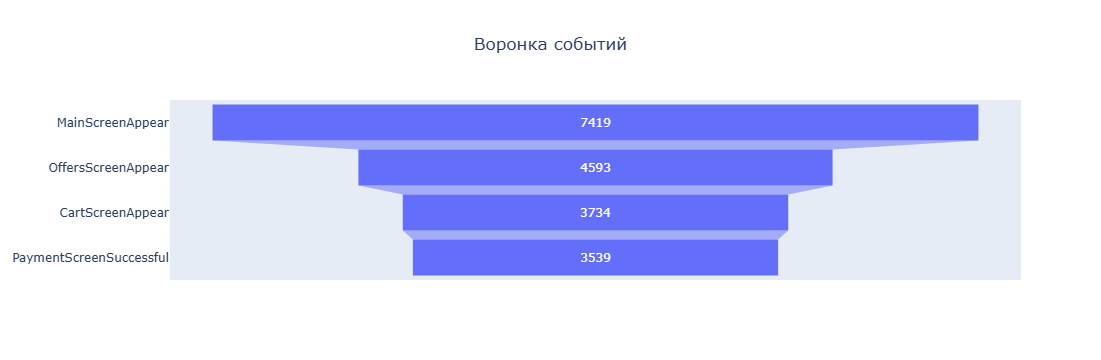

In [37]:
# второй способ построения воронки
from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y = event_name,
    x = event_value))

fig.update_layout(title="Воронка событий", title_x=0.5)

fig.show()

**Рассчитаем конверсию пользователей от шага к шагу и узнаем, на каком этапе теряем больше всего пользователей.**

In [38]:
# Создадим датафрейм "conversion"
conversion = data_full[data_full['event_name'] != 'Tutorial'].groupby('event_name', as_index=False).agg({'event_timestamp':'count','device_id_hash': 'nunique'})\
    .sort_values(by='device_id_hash', ascending=False).reset_index(drop=True).rename(columns={'event_timestamp': 'cnt_events', 'device_id_hash': 'users_unique'})

conversion['total_conv_user'] = np.round((conversion['users_unique'] / conversion.loc[0, 'users_unique']) * 100, 2)

for i in conversion.index:
    if i == 0:
        conversion['step_conv_user'] = np.round((conversion.loc[i, 'users_unique'] / conversion.loc[i, 'users_unique']) * 100, 2)
    else:
        conversion.loc[i, 'step_conv_user'] = np.round((conversion.loc[i, 'users_unique'] / conversion.loc[i - 1, 'users_unique']) * 100, 2)

conversion

,event_name,cnt_events,users_unique,total_conv_user,step_conv_user
0,MainScreenAppear,117328,7419,100.00,100.00
1,OffersScreenAppear,46333,4593,61.91,61.91
2,CartScreenAppear,42303,3734,50.33,81.30
3,PaymentScreenSuccessful,33918,3539,47.70,94.78


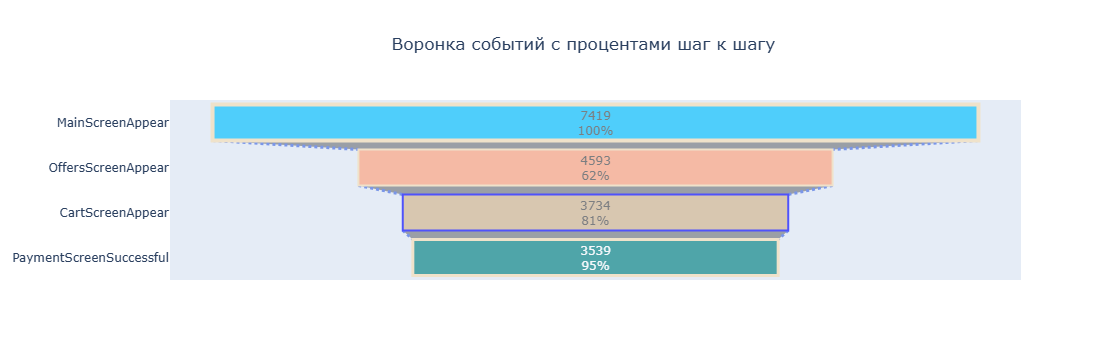

In [39]:
# воронка с процентами шаг к шагу
fig = go.Figure(go.Funnel(
    y = event_name,
    x = event_value,
    textposition = "inside",
    textinfo = "value+percent previous",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )

fig.update_layout(title="Воронка событий с процентами шаг к шагу", title_x=0.53)

fig.show()

*Больше всего пользователей теряется на этапе перехода от события с главным экраном* **"MainScreenAppear"** на событие **"OffersScreenAppear"**, *связанное с выбором товаров.*

In [40]:
# посчитаем долю пользователей, прошедших от первого экрана до покупки
top_users = conversion.loc[3, 'users_unique'] / data_full['device_id_hash'].nunique()
print(f'Доля пользователей, дошедших до последнего события составляет {top_users:.1%}')

Доля пользователей, дошедших до последнего события составляет 47.0%


**ВЫВОД 4**

В данном разделе мы выяснили, что всего событий 5:

1. Основной экран **MainScreenAppear** - частота 117328, количество пользователей 7419, доля 0.984736
2. Экран с товарами **OffersScreenAppear** - частота 46333, количество пользователей 4593, доля 0.609636
3. Корзина **CartScreenAppear** - частота 42303, количество пользователей 3734, доля 0.495620
4. Успешная оплата **PaymentScreenSuccessful** - частота 33918, количество пользователей 3539, доля 0.469737
5. Инструкция **Tutorial** - частота 1005, количество пользователей 840, доля 0.111495

На основании воронки было сделано предположение о том, что первые четыре события расположены в логичном порядке пути пользователя до покупки. Пятое событие-инструкцию **"Tutorial" решено исключить**, так как его частота чрезвычайно мала, а расположение не соответствует хронологии.

**Итог**

**Рассчет конверсии пользователей в шаг позволил выявить проблемное событие, на котором теряется больше всего пользователей.** Это событие **"OffersScreenAppear"**. Конверсия перехода на данное событие после главного экрана составляет чуть менее 62%, тогда, как на последующих этапах сохраняется не менее 80%. *Стоит обратить внимание на событие c главным экраном* **"MainScreenAppear"**, *так как, вероятнее всего именно на нем пользователей что-то смущает и он не переходит на экран с товарами.*

Конверсия пользователей, дошедших от первого события с главным экраном до последнего события и совершивих покупку составляет 47%, что является достаточно неплохим показателем в отрыве от иных метрик.

<a class='anchor' id='5-bullet'></a>
## Проведем эксперимент и изучим результаты

Мы уже визуализировали данные о количестве пользователей по группам. 

Выведем повторно количество уникальных пользователей по трем группам - 246 и 247 - контрольные, и 248 - экспериментальная.

In [41]:
# Выведем количество уникальных пользователей по группам
data_full.groupby('exp_id')['device_id_hash'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

Теперь приступим к созданию функции для проведения A/A-эксперимента.

### Проверим разницу между контрольными выборками 246 и 247

Для начала сформулируем гипотезы:

* **Нулевая гипотеза H0** - Конверсии двух контрольных групп 246 и 247 не различимы на всех этапах пути пользователя от посещения приложения до совершения покупки.
* **Альтернативная гипотеза H1** - Конверсии двух контрольных групп 246 и 247 различны, то есть доли пользователей на одних и тех же этапах в двух группах различны.

In [42]:
alpha = 0.05

# зададим функцию для статистической проверки разницы между группами по каждому событию в воронке
def a_a_test(event, group_1, group_2, alpha):
    
    # Количество пользователей в каждой группе
    users_cnt_gr1 = group_1['device_id_hash'].nunique()
    users_cnt_gr2 = group_2['device_id_hash'].nunique()
    
    # Количество пользователей по событиям
    ev_users_gr1 = group_1[group_1['event_name'] == event]['device_id_hash'].nunique()
    ev_users_gr2 = group_2[group_2['event_name'] == event]['device_id_hash'].nunique()
    
    # Доля пользователей, совершивших событие
    conversion_gr1 = ev_users_gr1 / users_cnt_gr1
    conversion_gr2 = ev_users_gr2 / users_cnt_gr2
    
    # Статистическая проверка разницы пропорций между группами
    count = np.array([ev_users_gr1, ev_users_gr2])
    nobs = np.array([users_cnt_gr1, users_cnt_gr2])
    z_stat, p_value = proportions_ztest(count, nobs)

    res = p_value < alpha
    
    return {
        'event': event,
        'conversion_group1': conversion_gr1,
        'conversion_group2': conversion_gr2,
        'p_value': p_value,
        'res': res
    }

In [43]:
# разделим данные на 3 датафрейма для 3 групп
group_246 = data_full[data_full['exp_id'] == 246]
group_247 = data_full[data_full['exp_id'] == 247]
group_248 = data_full[data_full['exp_id'] == 248]

# проверим разницу для событий в воронке
groups_246_247 = []
for i in event_name:
    groups_246_247.append(a_a_test(i, group_246, group_247, alpha))

# преобразуем резльтат работы функции в датафрейм
groups_246_247 = pd.DataFrame(groups_246_247)

print('Пара групп 246 vs 247')
groups_246_247

Пара групп 246 vs 247


,event,conversion_group1,conversion_group2,p_value,res
0,MainScreenAppear,0.986312,0.985277,0.757060,False
1,OffersScreenAppear,0.620773,0.604855,0.248095,False
2,CartScreenAppear,0.509662,0.492638,0.228834,False
3,PaymentScreenSuccessful,0.483092,0.460804,0.114567,False


**На первый взгляд конверсии двух контрольных групп идентичны.**

Визуализируем конверсии на графике.

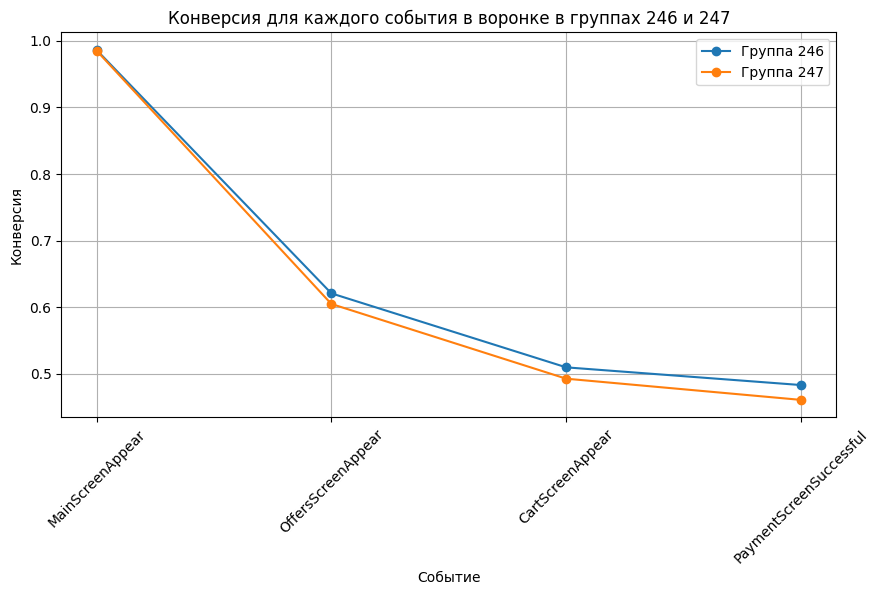

In [44]:
# построим график конверсии для групп 246 и 247
plt.figure(figsize=(10, 5))

plt.plot(groups_246_247['event'], groups_246_247['conversion_group1'], marker='o', label='Группа 246')
plt.plot(groups_246_247['event'], groups_246_247['conversion_group2'], marker='o', label='Группа 247')

plt.grid(True)
plt.xlabel('Событие')
plt.ylabel('Конверсия')
plt.title('Конверсия для каждого события в воронке в группах 246 и 247')
plt.legend()
plt.xticks(rotation=45)

plt.show()

*Вывод 5.1*

В датафрейме "test_a_a" собраны значения конверсии по группам 246 и 247 для каждого события, а также значения p-value.
На графике конверсии видно, что конверсия группы 246 немного выше конверсии группы 247. Однако тест пропорций показал, что минимальный p-value, принадлежащий событию "PaymentScreenSuccessful" равен 0.11. Данное значение превышает уровень статистической значимости, равный 0.05.

*Итог*

**Нулевая гипотеза H0 о равенстве конверсий групп 246 и 247 не отвергнута, так как статистически значимых различий нет. Конверсии этих групп равны.**

### Проведем A/A/B тест

In [45]:
# определим и выведем самое популярное событие
most_pop_event = conversion.loc[conversion['cnt_events'] == max(conversion['cnt_events']), 'event_name'][0]
print(f'Самое популярное событие {most_pop_event}')

Самое популярное событие MainScreenAppear


In [46]:
# выведем число пользователей в контрольных группах 246 и 247, совершивших самые популярные события
most_pop_event_246 = group_246.loc[group_246['event_name'] == most_pop_event, 'device_id_hash'].nunique()
most_pop_event_247 = group_247.loc[group_247['event_name'] == most_pop_event, 'device_id_hash'].nunique()

print(f'Количество пользователей, совершивших самое популярное событие в группе 246 равно {most_pop_event_246}')
print(f'Количество пользователей, совершивших самое популярное событие в группе 247 равно {most_pop_event_247}')

Количество пользователей, совершивших самое популярное событие в группе 246 равно 2450
Количество пользователей, совершивших самое популярное событие в группе 247 равно 2476


In [47]:
# рассчитаем долю этих пользователей
most_pop_event_ratio_246 = np.round(most_pop_event_246 / group_246['device_id_hash'].nunique(), 5)
most_pop_event_ratio_247 = np.round(most_pop_event_247 / group_247['device_id_hash'].nunique(), 5)

print(f'Доля пользователей совершивших самое популярное событие в группе 246 {most_pop_event_ratio_246}')
print(f'Доля пользователей совершивших самое популярное событие в группе 247 {most_pop_event_ratio_247}')

Доля пользователей совершивших самое популярное событие в группе 246 0.98631
Доля пользователей совершивших самое популярное событие в группе 247 0.98528


In [48]:
# проверим разницу для самого популярного события между контрольными группами
most_popular_event_result = a_a_test(most_pop_event, group_246, group_247, alpha)

most_popular_event_result = pd.DataFrame([most_popular_event_result])
# выведем датафрейм для самого популярного события
most_popular_event_result

,event,conversion_group1,conversion_group2,p_value,res
0,MainScreenAppear,0.986312,0.985277,0.75706,False


**Статистически значимых различий нет.**

#### Проверка групп 246vs248 и 247vs248

Теперь проверим различия для каждой пары из 3 групп (246, 247 и 248).

Сформулируем две новые пары гипотез.

1. *Гипотеза пары 246 vs 248*

* **H0 - Конверсии двух групп 246 и 248 одинаковы.**
* **H1 - Конверсии двух групп 246 и 248 различны.**

2. *Гипотеза пары 247 vs 248*

* **H0 - Конверсии двух групп 247 и 248 одинаковы.**
* **H1 - Конверсии двух групп 247 и 248 различны.**

Пара групп 246 VS 248


,event,conversion_group1,conversion_group2,p_value,res
0,MainScreenAppear,0.986312,0.982657,0.294972,False
1,OffersScreenAppear,0.620773,0.603469,0.208362,False
2,CartScreenAppear,0.509662,0.484825,0.078429,False
3,PaymentScreenSuccessful,0.483092,0.465510,0.212255,False


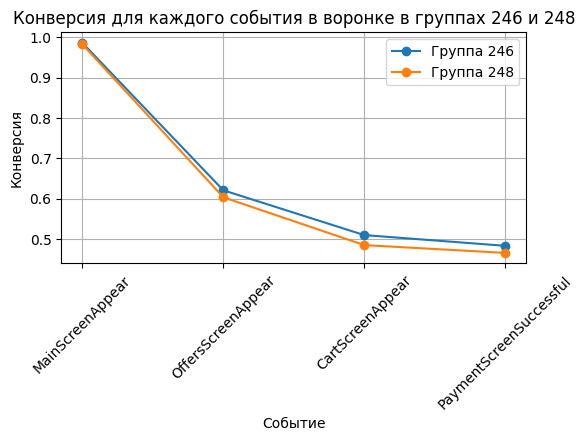

Пара групп 247 VS 248


,event,conversion_group1,conversion_group2,p_value,res
0,MainScreenAppear,0.985277,0.982657,0.458705,False
1,OffersScreenAppear,0.604855,0.603469,0.919782,False
2,CartScreenAppear,0.492638,0.484825,0.578620,False
3,PaymentScreenSuccessful,0.460804,0.465510,0.737342,False


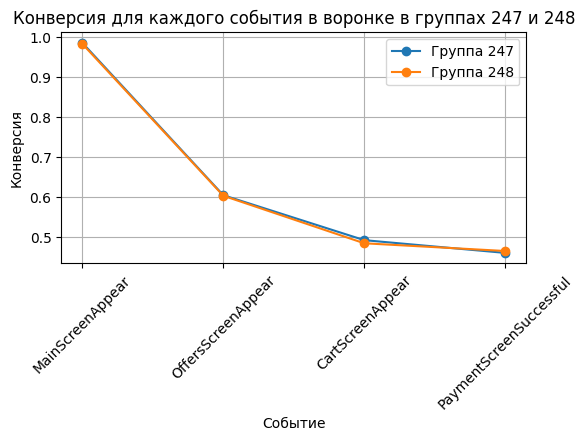

In [49]:
alpha = 0.05

# проведем тест для пар групп 246 vs 248 и 247 vc 248
groups_246_248 = []
groups_247_248 = []
for i in event_name:
    # пара 246 vc 248
    result_246_248 = a_a_test(i, group_246, group_248, alpha)
    groups_246_248.append(result_246_248)
    
    # пара 246 vc 248
    result_247_248 = a_a_test(i, group_247, group_248, alpha)
    groups_247_248.append(result_247_248)


# преобразуем резльтат работы функции в датафрейм
groups_246_248 = pd.DataFrame(groups_246_248)
groups_247_248 = pd.DataFrame(groups_247_248)

# выведем датафрем 246 vs 248
print('Пара групп 246 VS 248')
display(groups_246_248)

# построим график конверсии для групп 246 и 248
plt.figure(figsize=(6, 3))

plt.plot(groups_246_248['event'], groups_246_248['conversion_group1'], marker='o', label='Группа 246')
plt.plot(groups_246_248['event'], groups_246_248['conversion_group2'], marker='o', label='Группа 248')

plt.grid(True)
plt.xlabel('Событие')
plt.ylabel('Конверсия')
plt.title('Конверсия для каждого события в воронке в группах 246 и 248')
plt.legend()
plt.xticks(rotation=45)

plt.show()

# выведем датафрем 247 vs 248
print('Пара групп 247 VS 248')
display(groups_247_248)

# построим график конверсии для групп 247 и 248
plt.figure(figsize=(6, 3))

plt.plot(groups_247_248['event'], groups_247_248['conversion_group1'], marker='o', label='Группа 247')
plt.plot(groups_247_248['event'], groups_247_248['conversion_group2'], marker='o', label='Группа 248')

plt.grid(True)
plt.xlabel('Событие')
plt.ylabel('Конверсия')
plt.title('Конверсия для каждого события в воронке в группах 247 и 248')
plt.legend()
plt.xticks(rotation=45)

plt.show()

Различия в парах между контрольной группой и экспериментальной больше, чем между двумя контрольными.

Так, в паре 246 vs 248 минимальный p-value составляет 0.07 в событии "CartScreenAppear". Данное значение почти достигло популярного уровня статистической значимости в 0.05. Однако, ни в одной паре данный уровень так и не был достигнут.

**Нулевые гипотезы пар 246 vs 248 и пары 247 vs 248 не отвергнуты, так как статистически значимых различий не наблюдается.**

При этом стоит отметить, что p-value пары 246 vs 248 значительно ниже на всех событиях и не превышат отметки в 0.30. В то время, как у пары 247 vs 248 p-value не опускается ниже 0.45. *Данный факт говорит о значительно больших различиях между 246 и 248 группой, чем между 247 и 248, что подтвердили и построенные графики.*

**Итог 5.2.1:**

**Группы 246 и 248, а также 247 и 248 ИДЕНТИЧНЫ.**

#### Проверка групп 246+247 и 248

**Теперь сравним экспериментальную группу 248 с объединенной группой из двух контрольных 246 и 247.**

*Гипотезы объеденных данных контрольных групп 246 + 247 и экспериметнальной группы 248*

* **H0 - Конверсии объединенных данных контрольных групп 246 + 247 и экспериментальной группы 248 одинаковы.**
* **H1 - Конверсии объединенных данных контрольных групп 246 + 247 и экспериментальной группы 248 различны.**


Результаты для всех событий между объединенной группой (246+247) и экспериментальной группой (248):


,event,conversion_group1,conversion_group2,p_value,res
0,MainScreenAppear,0.985791,0.982657,0.294245,False
1,OffersScreenAppear,0.612768,0.603469,0.434255,False
2,CartScreenAppear,0.501101,0.484825,0.181759,False
3,PaymentScreenSuccessful,0.471883,0.465510,0.600429,False


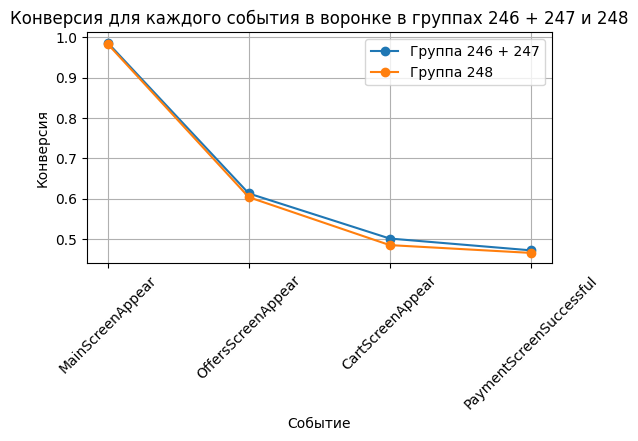

In [50]:
# объединим группы 246 и 247
joined_246_247 = pd.concat([group_246, group_247])

alpha = 0.05
# проведем тест для объединенной группы 246 + 247 и группы 248
joined_246_247_248 = []
for i in event_name:
    # Сравнение объединенной группы 246+247 с экспериментальной группой 248
    result_joined = a_a_test(i, joined_246_247, group_248, alpha)
    
    joined_246_247_248.append(result_joined)

# Создаем DataFrame из результатов для объединенной группы и экспериментальной группы
joined_246_247_248 = pd.DataFrame(joined_246_247_248)

# Отображаем результаты для всех событий между объединенной и экспериментальной группами
print("\nРезультаты для всех событий между объединенной группой (246+247) и экспериментальной группой (248):")
display(joined_246_247_248)

# построим график конверсии для объединенных групп 246 + 247 и 248
plt.figure(figsize=(6, 3))

plt.plot(joined_246_247_248['event'], joined_246_247_248['conversion_group1'], marker='o', label='Группа 246 + 247')
plt.plot(joined_246_247_248['event'], joined_246_247_248['conversion_group2'], marker='o', label='Группа 248')

plt.grid(True)
plt.xlabel('Событие')
plt.ylabel('Конверсия')
plt.title('Конверсия для каждого события в воронке в группах 246 + 247 и 248')
plt.legend()
plt.xticks(rotation=45)

plt.show()

P-value достигает минимума на событии "CartScreenAppear" и равняется 0.18, что значительно выше уровня статистической значимости alpha=0.05.

**Итог: 5.2.2**

**нет повода отвергать нулевую гипотезу, так между группами нет статистически значимых различий.**

#### Проведем расчет количества тестов.

Всего было проведено сравнение 4 пар групп:

1. **246** vs **247**
2. **246** vs **248**
3. **247** vs **248**
4. **246 + 247** vs **248**

В каждой паре сравнивались конверсии по 4 событиям.

**По итогу получается 16 проведенных тестов.**

**Воспользуемся поправкой Холма**

Примем уровень статистической значимости alpha = 0.1.
Проведем вновь проверку наличия статистически значимых различий при количестве тестов равном 16.

In [51]:
m, alpha = 16, 0.1 # число тестов и уровень значимости
result = []
for i in range(m): # получаем номер текущего теста и считаем коррекцию 
    result += [alpha / (m - i)] 

groups_246_247['gr'] = '246 vs 247'
groups_246_248['gr'] = '246 vs 248'
groups_247_248['gr'] = '247 vs 248'
joined_246_247_248['gr'] = '246 + 247 vs 248'
ob = pd.concat([groups_246_247, groups_246_248, groups_247_248, joined_246_247_248])
ob['holma'] = result
ob['res'] = ob['p_value'] < alpha
ob['res_holma'] = ob['p_value'] < ob['holma']
ob

,event,conversion_group1,conversion_group2,p_value,res,gr,holma,res_holma
0,MainScreenAppear,0.986312,0.985277,0.757060,False,246 vs 247,0.006250,False
1,OffersScreenAppear,0.620773,0.604855,0.248095,False,246 vs 247,0.006667,False
2,CartScreenAppear,0.509662,0.492638,0.228834,False,246 vs 247,0.007143,False
3,PaymentScreenSuccessful,0.483092,0.460804,0.114567,False,246 vs 247,0.007692,False
0,MainScreenAppear,0.986312,0.982657,0.294972,False,246 vs 248,0.008333,False
1,OffersScreenAppear,0.620773,0.603469,0.208362,False,246 vs 248,0.009091,False
2,CartScreenAppear,0.509662,0.484825,0.078429,True,246 vs 248,0.010000,False
3,PaymentScreenSuccessful,0.483092,0.465510,0.212255,False,246 vs 248,0.011111,False
0,MainScreenAppear,0.985277,0.982657,0.458705,False,247 vs 248,0.012500,False
1,OffersScreenAppear,0.604855,0.603469,0.919782,False,247 vs 248,0.014286,False


Примем уровень статистической значимости alpha = 0.1.
Проведем вновь проверку наличия статистически значимых различий при количестве тестов равном 4.

In [52]:
m, alpha = 4, 0.1 # число тестов и уровень значимости
result = []
for i in range(m): # получаем номер текущего теста и считаем коррекцию 
    result += [alpha / (m - i)]
print(result) 

ob = pd.concat([groups_246_247, groups_246_248, groups_247_248, joined_246_247_248])
ob['holma'] = result * 4
ob['res'] = ob['p_value'] < alpha
ob['res_holma'] = ob['p_value'] < ob['holma']
ob

[0.025, 0.03333333333333333, 0.05, 0.1]


,event,conversion_group1,conversion_group2,p_value,res,gr,holma,res_holma
0,MainScreenAppear,0.986312,0.985277,0.757060,False,246 vs 247,0.025000,False
1,OffersScreenAppear,0.620773,0.604855,0.248095,False,246 vs 247,0.033333,False
2,CartScreenAppear,0.509662,0.492638,0.228834,False,246 vs 247,0.050000,False
3,PaymentScreenSuccessful,0.483092,0.460804,0.114567,False,246 vs 247,0.100000,False
0,MainScreenAppear,0.986312,0.982657,0.294972,False,246 vs 248,0.025000,False
1,OffersScreenAppear,0.620773,0.603469,0.208362,False,246 vs 248,0.033333,False
2,CartScreenAppear,0.509662,0.484825,0.078429,True,246 vs 248,0.050000,False
3,PaymentScreenSuccessful,0.483092,0.465510,0.212255,False,246 vs 248,0.100000,False
0,MainScreenAppear,0.985277,0.982657,0.458705,False,247 vs 248,0.025000,False
1,OffersScreenAppear,0.604855,0.603469,0.919782,False,247 vs 248,0.033333,False


**Подитог**

При изменении уровня статистической значимости до alpha = 0.1 появилось отвержение нулевой гипотезы о равенстве групп 246 и 248, причем и в случае с 16 тестами, и в случае 4 тестов. Однако, применение поправки на множественную проверку гипотез Холма данного отвержения не произошло. Получается, мы избегаем совершения *ошибки 1 рода*, когда нулевая гипотеза неверно отвергается.

**ВЫВОД 5**

Наиболее популярным событием ожидаемо оказался *"MainScreenAppear"*.
Процент пользователей, совершивших данное действие составляет более 98%. А между контрольными группами статистически значимого различия выявлено не было (p-value = 0.75)

На основании 3 групп были сформулированы гипотезы и проведены тесты по каждому из 4 событий. Уровень статистической значимости был выбран равным 0.05.

1. **H0 - Конверсии группы 246 и 247 равны.** Отвергнуть данную гипотезу не удалось. Минимальный p-value составил 0.11.
2. **H0 - Конверсия группы 246 и 248 равны.** Отвергнуть данную гипотезу не удалось. Минимальный p-value составил 0.07.
3. **H0 - Конверсии группы 247 и 248 равны.** Отвергнуть данную гипотезу не удалось. Минимальный p-value составил 0.45.
4. **H0 - Конверсии объединенных групп 246 + 247 и 248 равны.** Отвергнуть данную гипотезу не удалось. Минимальный p-value составил 0.18.

Тестов было много, поэтому я решил провести поправку на множественную проверку гипотез методом Холма, а также изменить уровень значимости на 0.1, так как в одном из тестов p_value равняется 0.07. 

После повышения alpha до 0.1 произошла ошибка 1 рода - нулевая гипотеза была неверно отвергнута. Понять это помогла поправка Холма, согласно которой во всех тестах статистически значимых различий не наблюдается.

<a class='anchor' id='6-bullet'></a>
## ОБЩИЙ ВЫВОД

1. При выполнении проектной работы был проведен **исследовательский анализ данных**:
    1) *Стало известно следующее:*
       * Начальные данные охватывают период с25-07-2019 по 07-08-2019. 
       * Общее количество событий в логе составляет 243713
       * Количество уникальных событий составляет 5
       * Общее количество уникальных пользователей составляет 7551
       * В среднем на пользователя приходится 32.3 событий
       * Медианное значение количества событий на пользователя равно 20
       * Нормальным диапазоном значений количества событий на пользователя признан следующий: от 1 до 80 событий.
    3) *Построение столбчатых графиков показало:*
       * Количество событий распределено практически равномерно по группам. Однако, группа 248 отличается наибольшим количеством событий (85582), за ней расположилась группа 246 (80181 событий) и 247 (77950) - самая немногочисленная.
       * По количеству пользователей на первом месте также группа 248 (2542 пользователя), затем группа 247 (2520) и 246 (2489 пользователей).
       * По количеству событий на пользователя лидирует группа 248 (33.7), затем группа 246 (32.2) и 247 (30.9).
    4) *Столбчатый график динамики изменения количества событий по дням и группам показал*, что полнота данных начинается лишь с 01-08-2019. По этой причине мы отсекли события, предшествующие этой дате, тем самым "потеряв" 2826 событий (лишь 1.16% данных) и 17 пользователей.
    5) *Построение столбчатых графиков после очистки данных* также подтвердило равномерность удаленных данных, так как распределение мест по количеству событий, пользователей и событий, приходящихся на пользователей осталось прежним.

    **Мы избавились от неполных данных, при этом никак не повлияв на прежнее распределение данных. Нынешний промежуток наблюдений - с 01-08-2019 по 07-08-2019.  Теперь можно смело приступать к дальнейшим исследованиям.**



2. **Построение воронки событий** показало, что изначальное количество необходимо уменьшить до 4. Исключено событие "Tutorial", так как его частота чрезвычайно мала, а расположение не соответствует хронологии событий.
   События расположились в следующем порядке:
    1. Основной экран **MainScreenAppear** - частота 117328, количество пользователей 7419, доля 0.984736
    2. Экран с товарами **OffersScreenAppear** - частота 46333, количество пользователей 4593, доля 0.609636
    3. Корзина **CartScreenAppear** - частота 42303, количество пользователей 3734, доля 0.495620
    4. Успешная оплата **PaymentScreenSuccessful** - частота 33918, количество пользователей 3539, доля 0.469737
    5. Инструкция **Tutorial** - частота 1005, количество пользователей 840, доля 0.111495
  
Рассчет конверсии пользователей в шаг позволил выявить проблемное событие, на котором теряется больше всего пользователей. Это событие **"OffersScreenAppear"**. Конверсия перехода на данное событие после главного экрана составляет чуть менее 62%, тогда, как на последующих этапах сохраняется не менее 80%. **Стоит обратить внимание на событие c главным экраном **"MainScreenAppear"**, так как, вероятнее всего именно на нем пользователей что-то смущает и он не переходит на экран с товарами.

Конверсия пользователей, дошедших от первого события с главным экраном до последнего события и совершивих покупку составляет 47%, что является достаточно неплохим показателем в отрыве от иных метрик.

3. **Проведение A/A/B тестов показало следующий результат.**

    Наиболее популярным событием ожидаемо оказался *"MainScreenAppear"*.
    Процент пользователей, совершивших данное действие составляет более 98%. А между контрольными группами статистически значимого различия выявлено не было (p-value = 0.75)

    На основании 3 групп были сформулированы гипотезы и проведены тесты по каждому из 4 событий. Уровень статистической значимости был выбран равный 0.05.

    1. **H0 - Конверсии группы 246 и 247 равны.** Отвергнуть данную гипотезу не удалось. Минимальный p-value составил 0.11.
    2. **H0 - Конверсия группы 246 и 248 равны.** Отвергнуть данную гипотезу не удалось. Минимальный p-value составил 0.07.
    3. **H0 - Конверсии группы 247 и 248 равны.** Отвергнуть данную гипотезу не удалось. Минимальный p-value составил 0.45.
    4. **H0 - Конверсии объединенных групп 246 + 247 и 248 равны.** Отвергнуть данную гипотезу не удалось. Минимальный p-value составил 0.18.

    Тестов было много, поэтому я решил провести поправку на множественную проверку гипотез методом Холма, а также изменить уровень значимости на 0.1, так как в одном из тестов p_value равняется 0.07. 

    После повышения alpha до 0.1 произошла ошибка 1 рода - нулевая гипотеза была неверно отвергнута. Понять это помогла поправка Холма, согласно которой во всех тестах статистически значимых различий не наблюдается.

**ИТОГ**
<br>В ходе работы была установлена последовательность событий при продаже и построение воронки. Затем был проведен A/A/B-тест, в ходе которого было установлено, что изменение шрифта в приложении не оказывает заметного влияния на поведение пользователей. Результаты, полученные для всех групп, включая контрольную, экспериментальную, а также объединенную группы, были практически идентичными на каждом этапе воронки продаж, без каких-либо статистически значимых различий. Данный факт подтвердило и повышение уровня значимости до 0.1 и проведение поправки Холма.

Это свидетельствует о том, что замена шрифта не приводит к снижению вовлеченности или конверсии. Следовательно, дизайнеры могут внедрять новый шрифт без опасений, что это негативно повлияет на пользовательский опыт. 

**Рекоммендации**
<br>Для повышения уровня конверсии посетителей в покупатели стоит обратить внимание на этап перехода пользователя с главного экрана **"MainScreenAppear"** на экран с товарами **"OffersScreenAppear"**. Стоит попробовать создать более свежий, современный и понятный интерфейс главного экрана, а также проверить техническую составляющую перехода (проблема может крыться в долгой загрузке второй страницы).